# Directly compare Monaco to Elekta Linac iCOM

This notebook uses the PyMedPhys library to compare the collected iCOM delivery data directly to the recorded plan within Monaco's tel files.

![PyMedPhys](https://docs.pymedphys.com/_static/pymedphys.svg)

## Description of method

There are a few key stages required to make this notebook work. Firstly the iCOM stream from the Linac needs to be recorded to disk, this iCOM stream then needs to be archived and grouped by patient.

Once these iCOM streams are running the plan needs to be delivered on the machine being listened to. From this point the iCOM stream is then able to be compared directly to the Monaco tel file.

This comparison is done by calculating an MU Density upon which the difference is reported on using the Gamma comparison tool.

### iCOM stream service

A Windows service is created to listen to the iCOM stream. This service is made from a `.bat` file, an example of which can be seen at:

> https://github.com/CCA-Physics/physics-server/blob/8a0954e5/RCCC/icom/harry_listening.bat

To create this service the [`nssm`](https://nssm.cc/) tool is used, with an example of its usage available at:

> https://github.com/CCA-Physics/physics-server/blob/8a0954e5/RCCC/icom/services-install.bat

**Warning: Take Note**

A force closing of the service which is listening to the iCOM stream done in such a way that it is not able to properly close down the listening socket will cause the Linac being listened to raise an interlock which won't interupt the beam, but it will not let a new beam be delivered until the machine is logged out of and re-logged back in.

This can happen when the service is force killed, the host machine is force shutdown, or the network connection is abruptly disconnected. Normal shutdown of the service or machine should not have this effect.

### Grouping iCOM stream by patient

For the iCOM stream to be easily indexed in the future deliveries are stored by patient id and name. This is done by setting up a `.bat` file to run on machine boot. An example `.bat` file that achieves this can be seen at:

> https://github.com/CCA-Physics/physics-server/blob/8a0954e5/RCCC/icom/patient_archiving.bat

### Reading the iCOM file, Monaco file, and comparing them

The resulting files are then loaded into a PyMedPhys Delivery object from which an MU Density can be calculated and used as a comparison and reporting tool.

These steps will be further expanded on below, prior to the lines of code that implement them.

## Importing the required libraries

### Third party libraries

In [1]:
import pathlib  # for filepath path tooling
import lzma  # to decompress the iCOM file

import numpy as np  # for array tooling
import matplotlib.pyplot as plt  # for plotting

### Importing PyMedPhys

PyMedPhys contains all the tooling to log the iCOM stream, read the iCOM stream, read Monaco tel files, create an MU Density, and compare the results using a Gamma implementation

![PyMedPhys](https://docs.pymedphys.com/_static/pymedphys.svg)

In [2]:
# Makes it so that any changes in pymedphys is automatically
# propagated into the notebook without needing a kernel reset.
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

In [3]:
import pymedphys

## Patient ID Configuration

Provide here the Patient ID, this will be used to look up the iCOM file record as well as the Monaco tel file record.

In [4]:
patient_id = '015112'

## File Path Configurations

Here is where the various root paths of the data has been stored.

### Input directories

In [5]:
icom_directory = pathlib.Path(r'\\physics-server\iComLogFiles\patients')
monaco_directory = pathlib.Path(r'\\monacoda\FocalData\RCCC\1~Clinical')

### Output directories

The `output_directory` below presents the location where raw results are saved for the permanent record.

The `pdf_directory` is designed to be a sub-directory of the Mosaiq eScan directory so that created PDFs can be easily imported into Mosaiq for reporting purposes.

In [6]:
output_directory = pathlib.Path(r'S:\Physics\Patient Specific Logfile Fluence')
pdf_directory = pathlib.Path(r'P:\Scanned Documents\RT\PhysChecks\Logfile PDFs')

## MU Density and Gamma configuration

MU Density and Gamma have a range of options available to them. Here are is where those options are configured.

In [7]:
GRID = pymedphys.mudensity.grid()
COORDS = (GRID["jaw"], GRID["mlc"])

GAMMA_OPTIONS = {
    'dose_percent_threshold': 2,  # Not actually comparing dose though
    'distance_mm_threshold': 0.5,
    'local_gamma': True,
    'quiet': True,
    'max_gamma': 2,
}

## Choosing from the available Monaco Plans and iCOM Deliveries

For the Patient ID provided the following two cells list out all the `tel` files and `iCOM` delivery files that were found. Run both of these cells below and then choose the appropriate plan and delivery in the third cell.

### Monaco Plans

In [8]:
all_tel_paths = list(monaco_directory.glob(f'*~{patient_id}/plan/*/tel.1'))
all_tel_paths

[WindowsPath('//monacoda/FocalData/RCCC/1~Clinical/1~015112/plan/LeftIlium1/tel.1'),
 WindowsPath('//monacoda/FocalData/RCCC/1~Clinical/1~015112/plan/RightLung/tel.1')]

In [9]:
plan_names_to_choose_from = [
    path.parent.name for path in all_tel_paths
]
plan_names_to_choose_from

['LeftIlium1', 'RightLung']

### iCOM Deliveries

In [10]:
icom_deliveries = list(icom_directory.glob(f'{patient_id}_*/*.xz'))
icom_deliveries

[WindowsPath('//physics-server/iComLogFiles/patients/015112_NAME, REDACTED/20200213_133208.xz')]

In [11]:
icom_files_to_choose_from = [
    path.stem for path in icom_deliveries
]
icom_files_to_choose_from

['20200213_133208']

### Plan and iCOM choice

Provide the directory name for the monaco plan and the timestamp for the iCOM delivery which you wish to compare.

In [12]:
monaco_plan_name = 'LeftIlium1'  # plan directory name
icom_delivery = '20200213_133208'  # iCOM timestamp

### Resulting paths found matching provided search query

In [13]:
tel_path = list(monaco_directory.glob(f'*~{patient_id}/plan/{monaco_plan_name}/tel.1'))[-1]
tel_path

WindowsPath('//monacoda/FocalData/RCCC/1~Clinical/1~015112/plan/leftilium1/tel.1')

In [14]:
icom_path = list(icom_directory.glob(f'{patient_id}_*/{icom_delivery}.xz'))[-1]
icom_path

WindowsPath('//physics-server/iComLogFiles/patients/015112_NAME, REDACTED/20200213_133208.xz')

## Loading the iCOM file

In order to save space on disk the patient iCOM streams are compressed using `lzma`. The following code opens these compressed files and gets the raw iCOM stream.

In [15]:
with lzma.open(icom_path, 'r') as f:
    icom_stream = f.read()

## Delivery Objects

Within PyMedPhys there is a `Delivery` object. This object can be created from a range of sources such as RT Plan DICOM files, Mosaiq SQL queries, iCOM data, trf log files, as well as Monaco tel files.

From this `Delivery` object many tasks can be undergone. The available methods and attributes on the `Delivery` object are given below:

In [16]:
# Print out available methods and attributes on the Delivery object
[command for command in dir(pymedphys.Delivery) if not command.startswith('_')]

['collimator',
 'combine',
 'count',
 'from_dicom',
 'from_icom',
 'from_logfile',
 'from_monaco',
 'from_mosaiq',
 'gantry',
 'index',
 'jaw',
 'merge',
 'mlc',
 'monitor_units',
 'mu',
 'mudensity',
 'to_dicom']

### Creating the Delivery Objects

We can create two of these `Delivery` objects, one from the iCOM stream, and the other from the Monaco tel file.

In [17]:
delivery_icom = pymedphys.Delivery.from_icom(icom_stream)
delivery_tel = pymedphys.Delivery.from_monaco(tel_path)

### Using the Delivery Objects

Once we have two Delivery objects we can calculate the MU Density of these. Of note, this same method of using the `Delivery` object can also be employed to compare to an RT Plan file, Elekta Linac TRF log file, or Mosaiq SQL.

In [18]:
mudensity_icom = delivery_icom.mudensity()
mudensity_tel = delivery_tel.mudensity()

## Calculating Gamma

PyMedPhys also has within it tooling to calculate Gamma. This is done below.

In [19]:
def to_tuple(array):
    return tuple(map(tuple, array))

gamma = pymedphys.gamma(
    COORDS,
    to_tuple(mudensity_tel),
    COORDS,
    to_tuple(mudensity_icom),
    **GAMMA_OPTIONS
)

## Create Plotting and Reporting Functions

So that we can view the result as well as create a PDF that can be stored within Mosaiq the following functions create these plots using the `matplotlib` library.

In [20]:
def plot_gamma_hist(gamma, percent, dist):
    valid_gamma = gamma[~np.isnan(gamma)]

    plt.hist(valid_gamma, 50, density=True)
    pass_ratio = np.sum(valid_gamma <= 1) / len(valid_gamma)

    plt.title(
        "Local Gamma ({0}%/{1}mm) | Percent Pass: {2:.2f} % | Max Gamma: {3:.2f}".format(
            percent, dist, pass_ratio * 100, np.max(valid_gamma)
        )
    )

In [21]:
def plot_and_save_results(
    mudensity_tel,
    mudensity_icom,
    gamma,
    png_filepath,
    pdf_filepath,
    header_text="",
    footer_text="",
):
    diff = mudensity_icom - mudensity_tel
    largest_item = np.max(np.abs(diff))

    widths = [1, 1]
    heights = [0.3, 1, 1, 1, 0.1]
    gs_kw = dict(width_ratios=widths, height_ratios=heights)

    fig, axs = plt.subplots(5, 2, figsize=(10, 16), gridspec_kw=gs_kw)
    gs = axs[0, 0].get_gridspec()

    for ax in axs[0, 0:]:
        ax.remove()

    for ax in axs[1, 0:]:
        ax.remove()

    for ax in axs[4, 0:]:
        ax.remove()

    axheader = fig.add_subplot(gs[0, :])
    axhist = fig.add_subplot(gs[1, :])
    axfooter = fig.add_subplot(gs[4, :])

    axheader.axis("off")
    axfooter.axis("off")

    axheader.text(0, 0, header_text, ha="left", wrap=True, fontsize=30)
    axfooter.text(0, 1, footer_text, ha="left", va="top", wrap=True, fontsize=6)

    plt.sca(axs[2, 0])
    pymedphys.mudensity.display(GRID, mudensity_tel)
    axs[2, 0].set_title("Monaco Plan MU Density")

    plt.sca(axs[2, 1])
    pymedphys.mudensity.display(GRID, mudensity_icom)
    axs[2, 1].set_title("Recorded iCOM MU Density")

    plt.sca(axs[3, 0])
    pymedphys.mudensity.display(
        GRID, diff, cmap="seismic", vmin=-largest_item, vmax=largest_item
    )
    plt.title("iCOM - Monaco")

    plt.sca(axs[3, 1])
    pymedphys.mudensity.display(GRID, gamma, cmap="coolwarm", vmin=0, vmax=2)
    plt.title(
        "Local Gamma | "
        f"{GAMMA_OPTIONS['dose_percent_threshold']}%/"
        f"{GAMMA_OPTIONS['distance_mm_threshold']}mm")

    plt.sca(axhist)
    plot_gamma_hist(
        gamma, 
        GAMMA_OPTIONS['dose_percent_threshold'], 
        GAMMA_OPTIONS['distance_mm_threshold'])

    return fig

## Plotting and saving the report

Now that have our data, and have formatted our report as we wish let's create and save this report as a png.

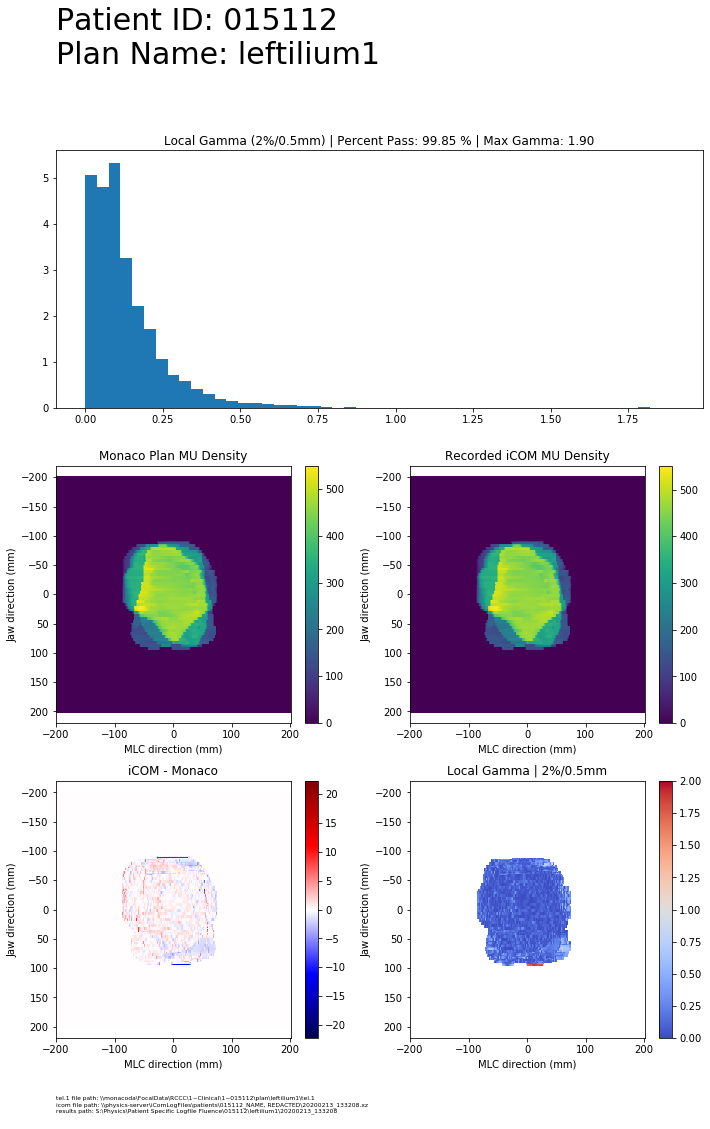

In [22]:
results_dir = output_directory.joinpath(patient_id, tel_path.parent.name, icom_path.stem)
results_dir.mkdir(exist_ok=True, parents=True)

header_text = (
    f"Patient ID: {patient_id}\n"
    f"Plan Name: {tel_path.parent.name}\n"
)

footer_text = (
    f"tel.1 file path: {str(tel_path)}\n"
    f"icom file path: {str(icom_path)}\n"
    f"results path: {str(results_dir)}"
)

png_filepath = str(results_dir.joinpath("result.png").resolve())
pdf_filepath = str(pdf_directory.joinpath(f"{patient_id}.pdf").resolve())

fig = plot_and_save_results(
    mudensity_tel, mudensity_icom, 
    gamma, png_filepath, pdf_filepath, 
    header_text=header_text, footer_text=footer_text
)

fig.tight_layout()
plt.savefig(png_filepath, dpi=300)
plt.show()

## Converting PNG to PDF for importing into Mosaiq

To create a pdf, the just created png file can be converted to pdf. To do this the tool [`imagemagick`](https://imagemagick.org/) needs to be installed on your system. If you install this now you will need to reset your Jupyter server in a new command prompt so that the `magick` command is available within your path.

In [23]:
!magick convert "{png_filepath}" "{pdf_filepath}"

## Uploading to Mosaiq

This created PDF should now be within your eSCAN directory and it can be uploaded onto the patient record.

## Further work

All of the above is able to be automated as long as there is a robust way to align iCOM delivery records to the correct corresponding Monaco tel file.